## Exercise 7: Ridge Regression for Prediction and Causal Inference

In [39]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from typing import List, Optional, Tuple, Dict, Callable

### Task 1: Ridge Regression


In lecture we have learned that in *ridge regression*, we want to minimize the loss function 
$$
L(\beta) = \sum_{i=1}^n \left(y_i-\beta_0-\sum_{j=1}^p\beta_j x_{ij}\right)^2 + \lambda \sum_{j=1}^p \beta_j^2.
$$

#### a) Implementing the Loss

Implement a function that computes the value of the loss function, using the signature in the cell below. Assume that the first column of your input matrix $X$ has all-constant values $1$ to model the intercept. 

In [40]:
def loss(X: np.ndarray, y: np.ndarray, beta: np.ndarray, reg: float) -> float:
    """
    :param X: 2-dimensional numpy array of features 
    :param y: 1-dimensional array of target values
    :param beta: current parameter vector
    :param reg: float, regularization term (lambda)
    :
    :return: AUC score as float
    """
    sse = np.sum(np.square(np.dot(X,beta) - y))
    norm = np.sum(np.square(beta))
    return sse + reg*norm

#### b) Convexity of the Loss

We explore the cost function with a practical example. Load the Iris dataset, and set up a univariate regression in which you predict petal width from petal length.
Set  $\beta_0 = mean(y)$ and $\lambda = 1$, and plot the value of the cost function against $\beta_1$ for  $\beta_1 \in\{-10,-9.9,\dots,9.9,10\}$.  
Is there a unique minimum? What is the sign of the derivative at $\beta = -3$ and $\beta = 3$? In which direction does it point - in direction of the minimum or against it?

In [41]:
from sklearn import datasets
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [42]:
X = iris.data[:,2]
y = iris.data[:,3]

X = np.vstack([np.ones(len(X)),X]).T

b0 = np.mean(y)
losses = []
iv = np.arange(-10,10, step = 0.1)
for b1 in iv:
    losses.append(loss(X,y,np.array([b0,b1]),1))

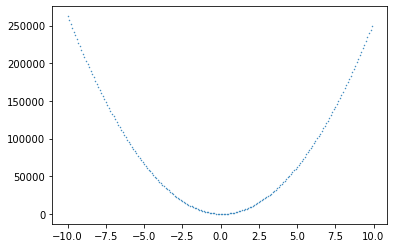

In [43]:
from matplotlib import pyplot as plt

plt.scatter(iv,losses,s=0.2)
plt.show()

#### c) Gradient Descent

In practice, regularized regression models regression are usually optimized by a variant of gradient descent. As discussed in lecture, in this iterative procedure one first initializes $\beta$ at random, and then, until convergence, one updates
$$\beta^{new} \gets \beta^{old} - \alpha\cdot \nabla L(\beta^{old}), $$
where $\alpha$ is the so-called learning rate, and $\nabla L(\beta)$ the gradient of the loss function with respect to $\beta$.
As discussed in lecture, the gradient of the loss function is given by 
$$
\frac{\partial C(\beta)}{\partial \beta_k} = \sum_{i=1}^n -2x_{ik} \left(y_i-\beta_0-\sum_{j=1}^p\beta_j x_{ij}\right) + 2\lambda\beta_k,
$$
where for $\beta_0$, we would have $x_{ik}=1$.

Implement a function that optimizes a ridge regression model via gradient descent, using the function signature in the cell below. Initialize your model in a way that $\beta_0$ equals the mean of $y$ and all other elements of $\beta$ are drawn from the standard normal distribution.

In [44]:
def ridge_GD(X: np.ndarray, y: np.ndarray, reg: float, alpha: float, eps: float, max_iter: int=10000) -> Tuple[np.ndarray,int,np.ndarray]:
    """
    :param X: 2-dimensional numpy array of features 
    :param y: 1-dimensional array of target values
    :param reg: regularization term (lambda)
    :param alpha: learning rate
    :param eps: convergence treshold
    :param max_iter: maximum number of iterations in gradient descent
    : -> break iteration when that number is reached even is we have not yet converged
    :
    :return: Tuple of three variables:
    :        1. 1D numpy array containing optimal coefficients beta
    :        2. number of iterations n_it
    :        3. vector of loss function values in every iteration
    :
    """
    n = (np.shape(X)[0])
    p = np.shape(X)[1] # p is the number of variables in the multiple regression
    
    # initilize beta vector
    b = np.random.normal(size=p+1)
    b[0] = np.mean(y)
    X = np.insert(X, 0, values=1, axis=1) # add a column of ones s.t. y=X*b

    # initialize losses
    losses = [loss(X,y,b,reg)]
    n_it = 0
    diff = eps+1
    
    # now the gradient descent:
    while n_it < max_iter and diff > eps:
        
        b_old = np.copy(b)
        res = (y - np.dot(X,b)) # residual from prediction with current beta
        
        # gradient computation can be written in a compact way
        d_b = (-1)*np.dot(X.T,(2*res))+2*reg*b # derivative w.r.t. b
        
        # parameter update
        b = b_old - alpha*d_b
        losses.append(loss(X,y,b,reg))
        diff = np.linalg.norm(losses[-1]-losses[-2])
        
        n_it+=1
      
    if n_it >=max_iter:
        print("Iteration has not yet converged")
        
    return b, n_it, losses

#### d) Regressing on Iris Data
Rescale the numerical columns of the Iris data by the z-score and apply your implementation from c) to predict the petal width from all other columns, using $\lambda = 1$, $\alpha=0.001$, $\epsilon=10^{-6}$. Compare the resulting parameters with those resulting from the ```statsmodels``` implementation of regularized regression fits!

In [45]:
from scipy.stats import zscore

X = iris.data[:,:-2]

X = pd.DataFrame(X).apply(zscore)
X = X.to_numpy()

In [46]:
beta,n_it,losses = ridge_GD(X,y,reg=1,alpha=1e-03,eps=1e-06)
print(beta)
print(n_it)
print(beta,n_it,losses)

[ 1.19139121  0.59301713 -0.20704886]
27
[ 1.19139121  0.59301713 -0.20704886] 27 [1235.727199817765, 557.1892413103682, 258.73340821833926, 127.41463286718712, 69.612301250205, 44.15729205591773, 32.94082485633969, 27.99488344965184, 25.812061198186704, 24.84768995994245, 24.421088494329194, 24.232086332725487, 24.14819583874661, 24.110877752456638, 24.094233199094226, 24.086786132747523, 24.083441853057625, 24.081933517319612, 24.081249805637086, 24.080938094664692, 24.080795048853606, 24.080728920744356, 24.080698101749206, 24.080683611421875, 24.080676734005237, 24.080673437478943, 24.080671841266764, 24.08067106043177]


In [47]:
#solution with statsmodels

# need to add constant term
X = sm.add_constant(X)

# initialize model: OLS = ordinary least squares
model = sm.OLS(y,X)
# fit model: only now the model, i.e. the parameters are computed
results = model.fit_regularized(alpha=1e-03, L1_wt=0)
results.params

array([ 1.1981352 ,  0.59635388, -0.20782215])

#### e) The Effect of the Learning Rate

Reoptimize your model using different learning rates $\alpha \in \{10^{-i} : i\in\{1,2,3,4,5,6\}\}$.
What are the effects on your optimization?

In [48]:
for alpha in [1e-01,1e-02,1e-03,1e-04,1e-05,1e-06]:
    beta,n_it,losses = ridge_GD(X,y,reg=1,alpha=alpha,eps=1e-06)
    print((alpha,n_it,beta,losses[-1]))


C:\Users\vahee\AppData\Local\Temp/ipykernel_21384/3399361051.py:10: RuntimeWarning: overflow encountered in square
  sse = np.sum(np.square(np.dot(X,beta) - y))
C:\Users\vahee\AppData\Local\Temp/ipykernel_21384/3399361051.py:11: RuntimeWarning: overflow encountered in square
  norm = np.sum(np.square(beta))
C:\Users\vahee\AppData\Local\Temp/ipykernel_21384/3847829045.py:42: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(losses[-1]-losses[-2])


(0.1, 88, array([ 3.68313915e+155,  3.68313915e+155, -2.67004164e+140,
       -5.76981041e+140]), inf)
(0.01, 221, array([-4.79944729e+153, -4.79944729e+153,  3.34369587e+138,
        7.63471798e+138]), inf)
(0.001, 1794, array([ 0.60882968,  0.58651916,  0.59308902, -0.2070336 ]), 23.368855402031596)
Iteration has not yet converged
(0.0001, 10000, array([ 0.65615325,  0.53919559,  0.59308902, -0.2070336 ]), 23.375446069250263)
Iteration has not yet converged
(1e-05, 10000, array([ 0.84537627,  0.34997257,  0.59308902, -0.2070336 ]), 23.491318934702754)
Iteration has not yet converged
(1e-06, 10000, array([ 1.94338017, -0.75178151,  0.42391033, -0.37567351]), 34.61257021465487)


### Task 2: Causal Inference 

In this task we use a dataset (NSW.csv) which aimed to evaluate the effect of participating in a job training program on the salary. This data was taken from the website of Gelman and Hill's book (http://www.stat.columbia.edu/~gelman/arm/), and originally constructed in two independent studies (see Gelman and Hill, chapter 10, ex. 1).
This data contains some demographic data of its population, the real earnings in 1974 and 1975, and indicator on whether job training, i.e., the treatment, was conducted in 1976/77, and the earnings in 1978, which is our target variable. A brief documentation can be found in "NSW.doc". Make sure that when loading the data, you omit the sample variable which simply indicates a source that a specific observation originated from.  
Note that there are only very few treated individuals in the dataset.g.

In [11]:
dta = pd.read_csv("NSW.csv", index_col=0)
dta.head()

,age,educ,black,married,nodegree,re74,re75,re78,hisp,sample,treat,educ_cat4
1,42,16,0,1,0,0.000000,0.000000,100.485405,0,2,0,4
2,20,13,0,0,0,2366.794189,3317.467773,4793.745117,0,2,0,3
3,37,12,0,1,0,25862.322266,22781.855469,25564.669922,0,2,0,2
4,48,12,0,1,0,21591.121094,20839.355469,20550.744141,0,2,0,2
5,51,12,0,1,0,21395.193359,21575.177734,22783.587891,0,2,0,2


#### a) Implementing Stratification

Write a function that applies stratification for causal inference and computes the corresponding average treatment effect. 
Make sure to introduce strata of (nearly) equal size, and apply a logistic regression classifier to model the propensity scores. Use the function signature specified in the cell below. 

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
def stratify(X: np.ndarray, y: np.ndarray, T: np.ndarray, n: int) -> float:
    """
    :param X: 2-dimensional numpy array of covariates, excluding treatment and target variable 
    :param T: 1-dimensional array of binary treatment values, corresponding to instances of X
    :param y: 1-dimensional array of target values
    :param n: number of strata to split the data into
    :
    :return: average treatment effect as float
    """    
    nrow = len(y)
    
    # compute propensity scores
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X,T)
    ps = clf.predict_proba(X)[:,1]
    
    # assign strata
    strata = np.ceil((ps.argsort()+1) / nrow*n)
    
    # helper variables
    T_y = T * y
    Tbar_y = (1-T) * y
    
    # iterate over strata
    res = 0.0
    for s in range(1,n+1):
        idx = np.where(strata == s)[0]
        n_tr = np.sum(T[idx])
        n_ct = len(idx) - n_tr
        res += 1.0/n_tr*(np.sum(T_y[idx])/n_tr - np.sum(Tbar_y[idx])/n_ct)
    
    return res


#### b) Applying Stratification

Apply your implementation from a) on the NSW data, using $n=5$ strata. Feel free to apply varying numbers of strata. Does a big number like $n>100$ make sense for this dataset?

In [14]:
pred_cols = ['age','black','hisp','married','educ','nodegree','re74','re75']
X = dta[pred_cols].to_numpy()
T = dta.treat.to_numpy()
y = dta.re78.to_numpy()

In [15]:
stratify(X, y, T, 5)

-1786.286462003439

__Answer:__ Due to only very few treated in the samples, large numbers of strata are a bad idea.

#### c) Implementing Propensity Score Weighting

Write a function that applies propensity score weighting for causal inference and computes the corresponding average treatment effect. Again, apply a logistic regression classifier to model the propensity scores. Use the function signature specified in the cell below. 

In [16]:
def propensity_weighting(X: np.ndarray, y: np.ndarray, T: np.ndarray) -> float:
    """
    :param X: 2-dimensional numpy array of covariates, excluding treatment and target variable 
    :param T: 1-dimensional array of binary treatment values, corresponding to instances of X
    :param y: 1-dimensional array of target values
    :
    :return: average treatment effect as float
    """    
    nrow = len(y)
    
    # compute propensity scores
    clf = LogisticRegression(max_iter = 10000)
    clf.fit(X,T)
    ps = clf.predict_proba(X)[:,1]
    
    # declare helper variables
    w = np.zeros(nrow)
    N_tr, N_ct = 0,0
    sum_tr, sum_ct = 0,0
    
    # iterate over all samples
    for i in range(nrow):
        
        # compute weight w_i
        w[i] = (T[i])/(ps[i]) + (1-T[i])/(1-ps[i])
        
        # update sums elementwise
        N_tr += T[i]/ps[i]
        N_ct += (1-T[i])/(1-ps[i])
        
        sum_tr += T[i]*w[i]*y[i]
        sum_ct += (1-T[i])*w[i]*y[i]
        
    return 1/N_tr * sum_tr - 1/N_ct * sum_ct 

#### d) Applying Propensity Score Weighting

Apply your implementation from c) on the NSW data, and compare the result to the ATE from b) as well as the unweighted and unstratified ATE. What do you observe?

In [17]:
propensity_weighting(X, y, T)

-8309.539404883646

__Answer__: Again, we seem to observe a very negative treatment effect.

#### e) Propensity Score Matching

Finally, we want to apply propensity score matching on the NSW data.
Note that due to the strong imbalance between the cardinalities of the control group and the treatment group, you do not need to consider a calliper in this task, and may implicitly assume that the treated group is much smaller in your implementation.

In [18]:
def propensity_matching(X: np.ndarray, y: np.ndarray, T: np.ndarray) -> float:
    """
    :param X: 2-dimensional numpy array of covariates, excluding treatment and target variable 
    :param T: 1-dimensional array of binary treatment values, corresponding to instances of X
    :param y: 1-dimensional array of target values
    :
    :return: average treatment effect as float
    """
    
    # compute propensity scores
    clf = LogisticRegression(max_iter = 10000)
    clf.fit(X,T)
    ps = clf.predict_proba(X)[:,1]
    
    y_treated = y[T==1]
    y_untreated = y[T==0]
    ps_treated = ps[T==1]
    ps_untreated = ps[T==0]
    
    idx_matches = []
    best_match=0
    for i,o2 in enumerate(ps_treated):
        
        #compute distances:
        distances = [abs(o1 - o2) for o1 in ps_untreated]
        
        # get best match via argmin
        best_match = np.argmin(distances)
        
        #store the matching
        idx_matches.append(best_match)
        
        # make sure that matched instances are not re-assigned
        ps_untreated[best_match] = np.inf
        
    return np.mean(y_treated - y_untreated[idx_matches])

#### f) Applying Greedy Matching

Apply your implementation from e) on the NSW data and use the matching to compute the ATE score on matched data, and compare the result to the ATEs from b) and d) as well as the unweighted and unstratified ATE. What do you observe?

In [19]:
propensity_matching(X, y, T)

803.4433216610468

__Answer__: According to propensity score matching, job training now seems to have a very positive effect on the income.